### Packages

In [1]:
import pickle
import time
from esda.moran import Moran
from libpysal.weights import Queen, KNN, W
import seaborn as sb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from clustergram import Clustergram
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from multiprocessing.pool import ThreadPool 

### Data

In [2]:
# main gdf
popgridmanchester = gpd.read_file("popgridmanchesterlatest.gpkg")

# subset of variables of interest
popgridsub = popgridmanchester.iloc[:,[4,11,18,21,22,25,27,30,31]+list(range(36,60))]

# variables of interest
cluster_variables = [col for col in popgridsub.columns if col != "geometry"]

# converting pop density to per km^2, will do this for the main gdf
popgridsub.buffer_pop_density = popgridsub.buffer_pop_density*1000000

# remove nans and inf values, resetting index
popgridsub = popgridsub.replace([np.inf, -np.inf], np.nan)
popgridsub = popgridsub.dropna()
popgridsub = popgridsub.reset_index()

# Robust scaling due to the range of values differing between variables
popgridsub_scaled = scale(popgridsub[cluster_variables])

C:\Users\julia\Python\Thesispy\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [126]:
# subset without network variables
popgridsub2 = popgridsub.iloc[:,[1,2]+list(range(10,34))]
cluster_variables2 = [col for col in popgridsub2.columns if col != "geometry"]
popgridsub_scaled2 = scale(popgridsub2[cluster_variables2])

In [14]:
# subset with only network variables
popgridsub3 = popgridsub.iloc[:,list(range(1,10))+[33]]
cluster_variables3 = [col for col in popgridsub3.columns if col != "geometry"]
popgridsub_scaled3 = scale(popgridsub3[cluster_variables3])

In [ ]:
# health data
healthdata = gpd.read_file("Greater_Manchester_NH_GIS.gpkg")

### Spatial autocorrelation tests

In [142]:
# creating weight matrix and row transforming due to mitigate bias due to features having different numbers of neighbors
w = Queen.from_dataframe(popgridsub)
w.transform = "R"

C:\Users\julia\Python\Thesispy\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 70 disconnected components.
 There are 47 islands with ids: 4045, 4095, 5703, 5704, 5882, 14861, 20797, 21388, 27472, 30944, 41978, 54220, 84793, 104667, 116169, 141226, 141245, 149285, 150774, 164917, 174411, 198750, 202226, 206597, 208610, 212539, 217362, 246590, 270528, 277947, 281715, 287499, 290436, 291223, 292693, 293925, 293928, 294156, 295182, 297722, 297793, 297824, 297826, 297827, 297866, 303168, 307808.
  warnings.warn(message)


('WARNING: ', 4045, ' is an island (no neighbors)')
('WARNING: ', 4095, ' is an island (no neighbors)')
('WARNING: ', 5703, ' is an island (no neighbors)')
('WARNING: ', 5704, ' is an island (no neighbors)')
('WARNING: ', 5882, ' is an island (no neighbors)')
('WARNING: ', 14861, ' is an island (no neighbors)')
('WARNING: ', 20797, ' is an island (no neighbors)')
('WARNING: ', 21388, ' is an island (no neighbors)')
('WARNING: ', 27472, ' is an island (no neighbors)')
('WARNING: ', 30944, ' is an island (no neighbors)')
('WARNING: ', 41978, ' is an island (no neighbors)')
('WARNING: ', 54220, ' is an island (no neighbors)')
('WARNING: ', 84793, ' is an island (no neighbors)')
('WARNING: ', 104667, ' is an island (no neighbors)')
('WARNING: ', 116169, ' is an island (no neighbors)')
('WARNING: ', 141226, ' is an island (no neighbors)')
('WARNING: ', 141245, ' is an island (no neighbors)')
('WARNING: ', 149285, ' is an island (no neighbors)')
('WARNING: ', 150774, ' is an island (no neigh

In [147]:
# Calculate Global Moran's I for each variable
mi_results = [
    Moran(popgridsub[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
population,0.769731,0.001
buffer_pop_density,0.984706,0.001
intersection_count,0.994120,0.001
street_length_avg,0.912215,0.001
circuity_avg,0.633191,0.001
intersection_density_km,0.044017,0.001
street_density_km,0.010956,0.001
streets_per_node_counts.2,0.952675,0.001
streets_per_node_counts.3,0.993912,0.001


### Spatial constrained hierarchical clustering

<Axes: >

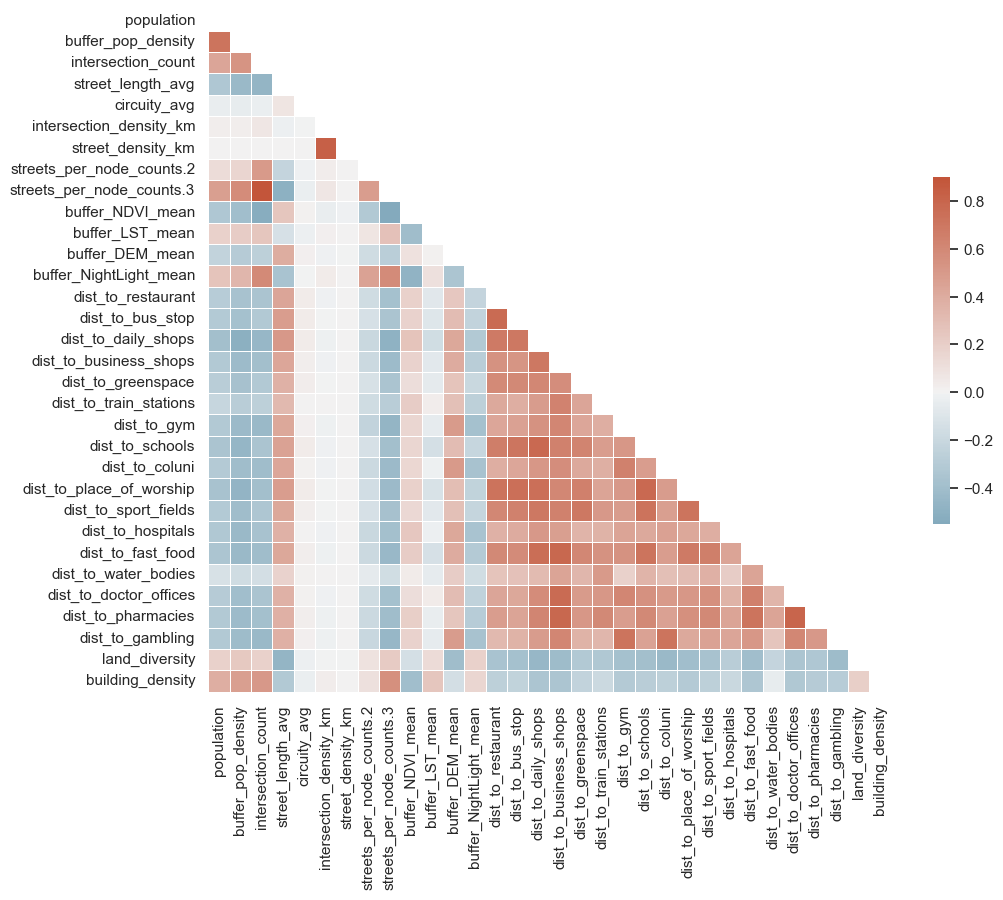

In [27]:
# correlation matrix of the variables
sb.set_theme(style="white")

# Compute the correlation matrix
corr = popgridsub[cluster_variables].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# subsetting to combine the vars that do not correlate and then use the subsets for hierarchical clustering


In [ ]:
K = range(2,21)
for k in K:
    # Initialize the algorithm
    model = AgglomerativeClustering(linkage="ward", n_clusters=k, connectivity=w.sparse)
    # Run clustering
    model.fit(popgridsub_scaled)
    popgridsub["agg_clustering_label_{}".format(k)] = model.labels_

In [49]:
# Goodness of fit tests for the amount of clusters
# We use the Calinski-Harabasz and Davies-Bouldin scores, higher is better for CH, lower is better for DB

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Davies-Bouldin score: The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#  where similarity is the ratio of within-cluster distances to between-cluster distances. 
#  Thus, clusters which are farther apart and less dispersed will result in a better score.

# Empty list for performance scores
performance_scores = []

# Loop through the cluster labels denoted from column 34
for cluster_count in popgridsub.columns[34:53]:
    # CH score
    ch_score = metrics.calinski_harabasz_score(scale(popgridsub[cluster_variables]), popgridsub[cluster_count])
    # DB score
    db_score = metrics.davies_bouldin_score(scale(popgridsub[cluster_variables]), popgridsub[cluster_count])
    # Append the cluster count, CH score, and DB score
    performance_scores.append((cluster_count, ch_score, db_score))

# Performance list to dataframe
df_performance = pd.DataFrame(performance_scores, columns=["Cluster Count", "CH Score", "DB Score"])

# Show
df_performance

,Cluster Count,CH Score,DB Score
0,agg_clustering_label_2,59348.703453,1.438110
1,agg_clustering_label_3,44243.874630,2.136660
2,agg_clustering_label_4,38586.359263,1.603939
3,agg_clustering_label_5,34301.149563,1.988083
4,agg_clustering_label_6,30696.125447,1.684933
5,agg_clustering_label_7,28326.792123,1.614736
6,agg_clustering_label_8,26113.170564,2.138163
7,agg_clustering_label_9,24270.380578,2.035812
8,agg_clustering_label_10,22896.163295,1.989016
9,agg_clustering_label_11,21737.097859,2.007348


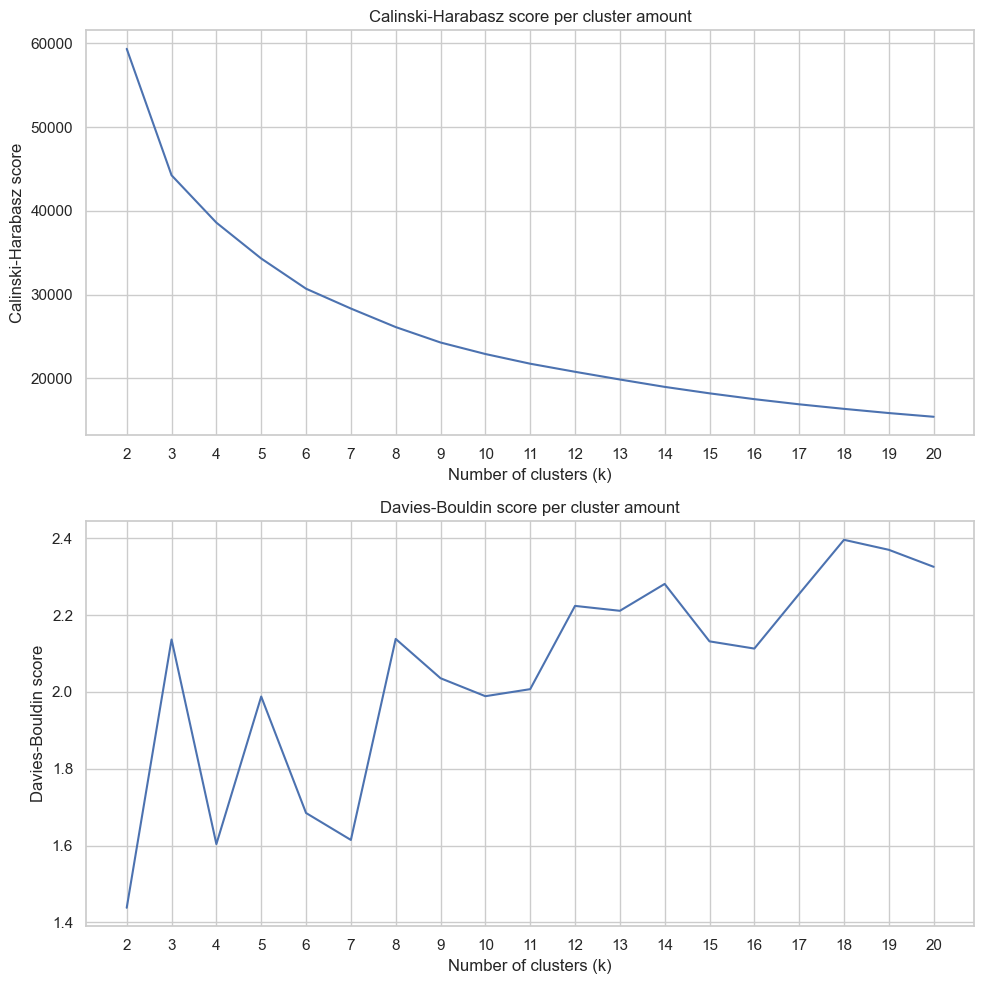

In [128]:
# Plotting the performance scores
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(K, df_performance['CH Score'])
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Calinski-Harabasz score")
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz score per cluster amount')
axs[1].plot(K, df_performance['DB Score'])
axs[1].set_xlabel("Number of clusters (k)")
axs[1].set_ylabel("Davies-Bouldin score")
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin score per cluster amount')
plt.tight_layout()
plt.show()

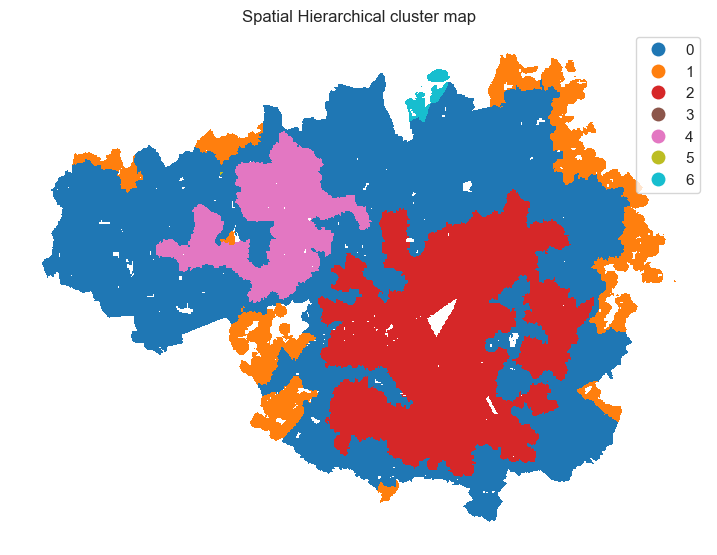

In [152]:
# Visualizing 7 clusters

# plotting results
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="agg_clustering_label_7",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.title("Spatial Hierarchical cluster map")
plt.show()

### Hierarchical clustering with clustergram
#### too memory-intensive

In [51]:
# Using clustergram with hierarchical clustering up to 20 clusters
cgram = Clustergram(range(1, 21), method='hierarchical', linkage='ward')
cgram.fit(popgridsub)

# Plotting the clustergram
seaborn.set(style='whitegrid')

cgram.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "lightblue", "edgecolor": "black"},
    line_style={"color": "red", "linestyle": "-."},
    figsize=(12, 8)
);

MemoryError: Unable to allocate 354. GiB for an array with shape (47579184003,) and data type float64

In [3]:
# goodness of fit tests for the amount of clusters
# We use the Davies-Bouldin and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Davies-Bouldin score: The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#  where similarity is the ratio of within-cluster distances to between-cluster distances. 
#  Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering..

# plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    xlabel="Number of clusters (k)",
    ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    xlabel="Number of clusters (k)",
    ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

In [ ]:
# plotting results
popgridsub["clustergram_label"] = cgram.labels[]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="clustergram_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

### K-means clustering with clustergram

In [116]:
# Using clustergram with k-means clustering up to 20 clusters
cgram_kmeans = Clustergram(range(2, 21), n_init=25, method='kmeans')

start_time = time.time()

#fit model
cgram_kmeans.fit(popgridsub_scaled)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

K=2 fitted in 3.015737771987915 seconds.
K=3 fitted in 3.1372413635253906 seconds.
K=4 fitted in 11.296127796173096 seconds.
K=5 fitted in 9.484164714813232 seconds.
K=6 fitted in 8.4657142162323 seconds.
K=7 fitted in 10.196593999862671 seconds.
K=8 fitted in 10.518393993377686 seconds.
K=9 fitted in 13.271138906478882 seconds.
K=10 fitted in 13.662186861038208 seconds.
K=11 fitted in 14.869878053665161 seconds.
K=12 fitted in 14.718684434890747 seconds.
K=13 fitted in 18.390925884246826 seconds.
K=14 fitted in 19.204128742218018 seconds.
K=15 fitted in 23.387380123138428 seconds.
K=16 fitted in 19.221139669418335 seconds.
K=17 fitted in 20.280039310455322 seconds.
K=18 fitted in 22.327308416366577 seconds.
K=19 fitted in 22.792728900909424 seconds.
K=20 fitted in 26.26741313934326 seconds.
Execution time: 284.52376914024353 seconds


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

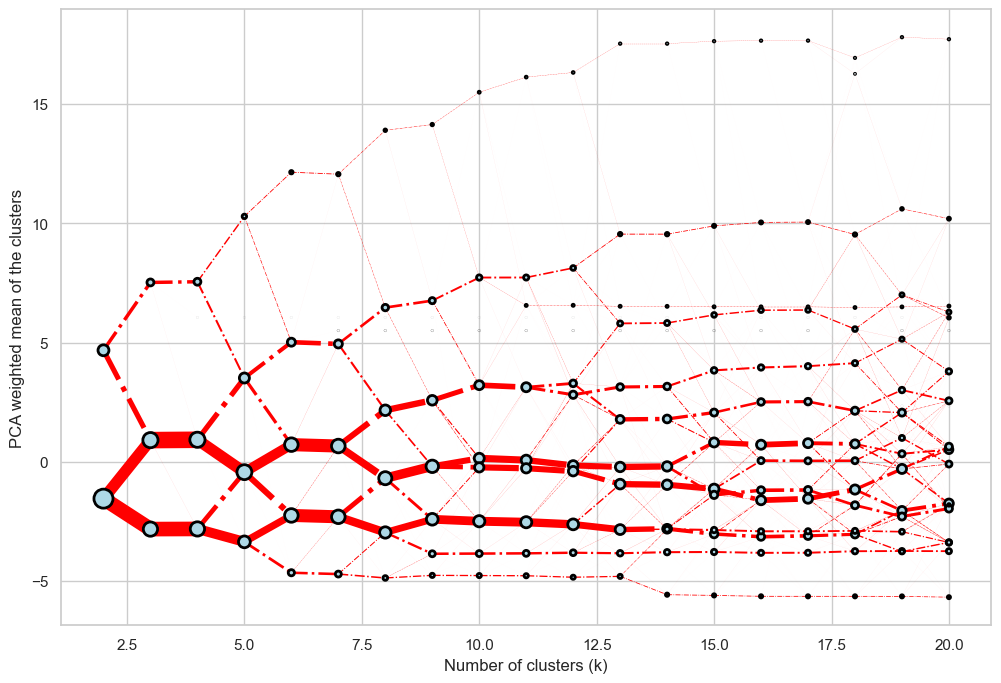

In [117]:
# plot cgram
sb.set(style='whitegrid')

cgram_kmeans.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "lightblue", "edgecolor": "black"},
    line_style={"color": "red", "linestyle": "-."},
    figsize=(12, 8)
)

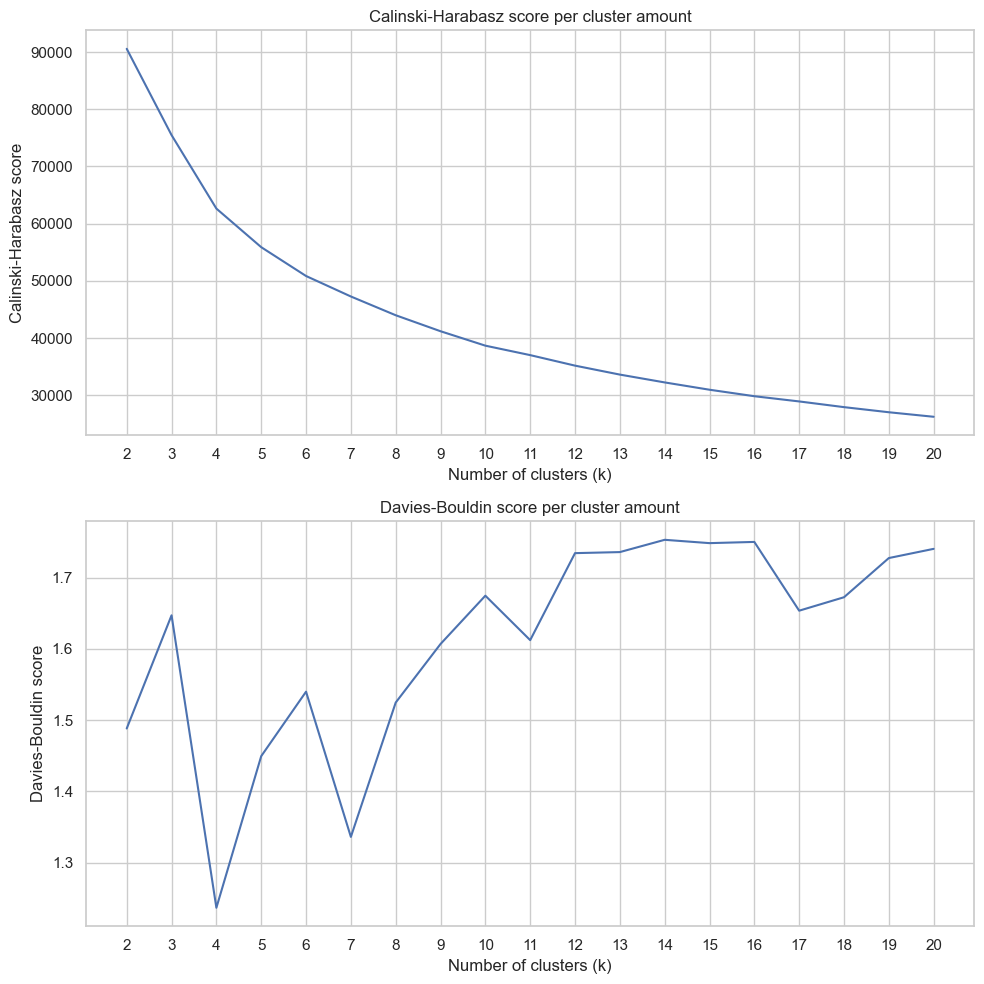

In [118]:
# Goodness of fit tests for the amount of clusters
# We use the Davies-Bouldin and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Davies-Bouldin score: The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#  where similarity is the ratio of within-cluster distances to between-cluster distances. 
#  Thus, clusters which are farther apart and less dispersed will result in a better score.

# getting the scores
kmeansch = cgram_kmeans.calinski_harabasz_score()
kmeansdb = cgram_kmeans.davies_bouldin_score()

# Plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(K, kmeansch)
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Calinski-Harabasz score")
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz score per cluster amount')
axs[1].plot(K, kmeansdb)
axs[1].set_xlabel("Number of clusters (k)")
axs[1].set_ylabel("Davies-Bouldin score")
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin score per cluster amount')
plt.tight_layout()
plt.show()

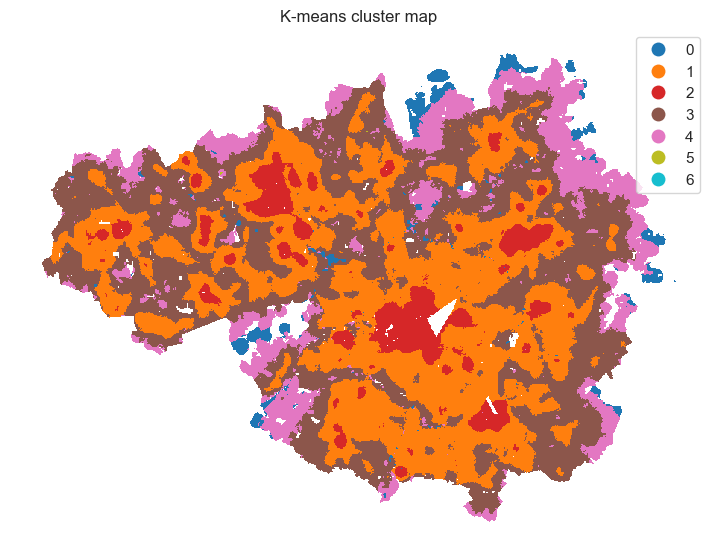

In [150]:
# Plotting results, 7 seems to be okay here
popgridsub["Kmeans_cluster_label"] = cgram_kmeans.labels[7]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="Kmeans_cluster_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.title("K-means cluster map")
plt.show()

### Gaussian mixture model with clustergram

In [97]:
# Using clustergram with GMM clustering up to 20 clusters
cgram_gmm = Clustergram(range(2, 21), method='gmm')

start_time = time.time()

#fit model
cgram_gmm.fit(popgridsub_scaled)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

K=2 fitted in 4.712390422821045 seconds.
K=3 fitted in 12.082188129425049 seconds.
K=4 fitted in 15.575828313827515 seconds.
K=5 fitted in 12.184971570968628 seconds.
K=6 fitted in 52.314653635025024 seconds.
K=7 fitted in 99.03813695907593 seconds.
K=8 fitted in 38.35846567153931 seconds.
K=9 fitted in 51.39904856681824 seconds.
K=10 fitted in 122.05049896240234 seconds.
K=11 fitted in 184.9095435142517 seconds.
K=12 fitted in 170.39475846290588 seconds.
K=13 fitted in 124.32994532585144 seconds.
K=14 fitted in 126.8499367237091 seconds.
K=15 fitted in 210.2267677783966 seconds.
K=16 fitted in 139.1791911125183 seconds.
K=17 fitted in 136.183354139328 seconds.
K=18 fitted in 164.7120292186737 seconds.
K=19 fitted in 400.42809796333313 seconds.
K=20 fitted in 260.22873711586 seconds.
Execution time: 2325.1784908771515 seconds


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

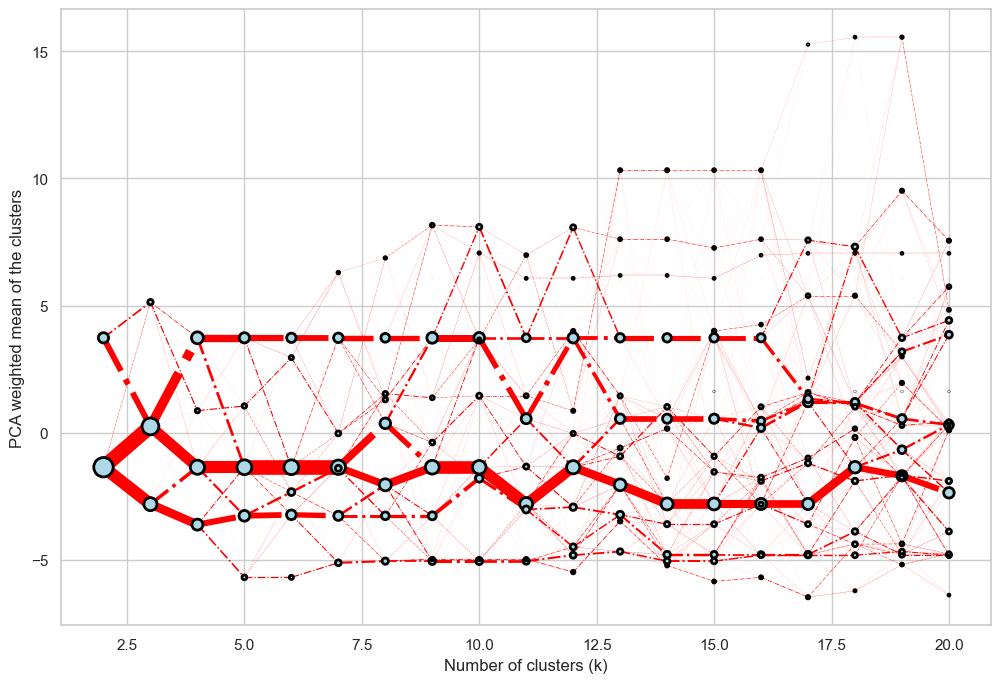

In [114]:
# plot cgram
sb.set(style='whitegrid')

cgram_gmm.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "lightblue", "edgecolor": "black"},
    line_style={"color": "red", "linestyle": "-."},
    figsize=(12, 8)
)

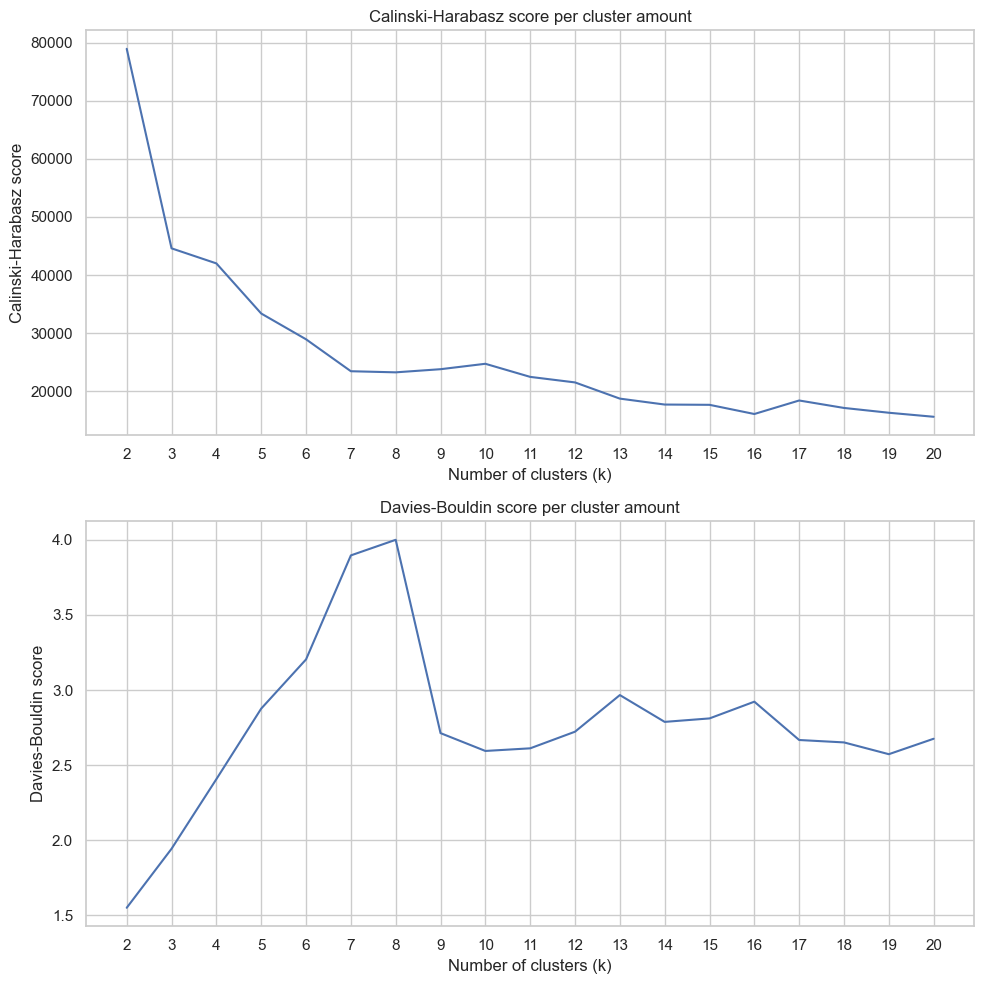

In [115]:
# Goodness of fit tests for the amount of clusters
# We use the Silhouette and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Davies-Bouldin score: The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#  where similarity is the ratio of within-cluster distances to between-cluster distances. 
#  Thus, clusters which are farther apart and less dispersed will result in a better score.

# getting the scores
gmmch = cgram_gmm.calinski_harabasz_score()
gmmdb = cgram_gmm.davies_bouldin_score()

# Plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(K, gmmch)
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Calinski-Harabasz score")
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz score per cluster amount')
axs[1].plot(K, gmmdb)
axs[1].set_xlabel("Number of clusters (k)")
axs[1].set_ylabel("Davies-Bouldin score")
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin score per cluster amount')
plt.tight_layout()
plt.show()

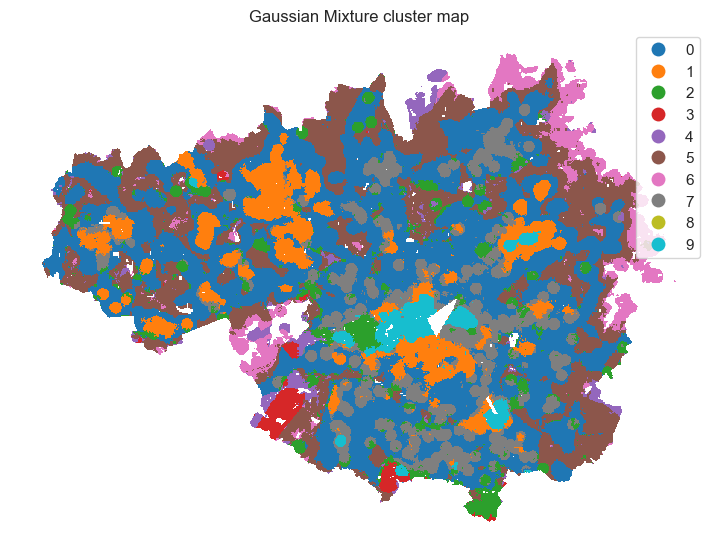

In [151]:
# Plotting results, 10 seems okay here
popgridsub["GMM_cluster_label"] = cgram_gmm.labels[10]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="GMM_cluster_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.title("Gaussian Mixture cluster map")
plt.show()

In [137]:
# save cgrams
with open('clustergram_kmeans.pickle','wb') as f:
    pickle.dump(cgram_kmeans, f)

with open('clustergram_gmm.pickle','wb') as f:
    pickle.dump(cgram_gmm, f)

### K-means without clustergram

In [104]:
inertias = []
mapping = {}

K = range(2, 21)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init=25)
    kmeanModel.fit(popgridsub_scaled)
    # Check the inertia amount
    inertias.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_

In [108]:
# Show inertia score per clusteramount
for key, val in mapping.items():
    print(f'{key} : {val}')

2 : 7630878.817407411
3 : 6627731.554990003
4 : 6134619.720742629
5 : 5723608.01085027
6 : 5411524.482886628
7 : 5143258.180507093
8 : 4940438.5729157645
9 : 4771327.126628452
10 : 4619949.403837172
11 : 4487396.917213483
12 : 4379013.246424385
13 : 4278320.489641586
14 : 4185301.6464750236
15 : 4104392.7782761957
16 : 4028625.500337477
17 : 3949477.9114379
18 : 3887684.8306204216
19 : 3829099.1421915567
20 : 3769938.775639628


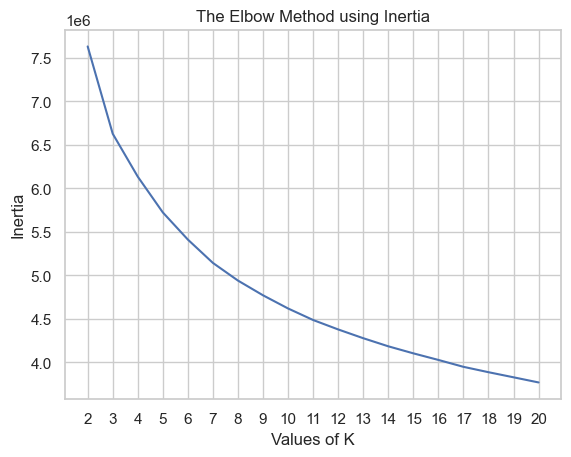

In [111]:
# plotting elbow plot
plt.plot(K, inertias)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.xticks(range(2,21))
plt.grid(True)
plt.show()